**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial import distance
from sklearn.neighbors import KDTree
#%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
#%%pycodestyle

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        knn = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
        self.x_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        data = self.predict_proba(X)
        y_knn = np.empty(X.shape[0])
        for i in range(X.shape[0]):
            y_knn[i] = data[i].argmax()

        return y_knn.astype('int')
    
    def predict_proba(self, X):
        prob = np.zeros(shape = (X.shape[0], np.unique(self.y_train).size))
        if self.algorithm == 'brute':
            dist = distance.cdist(X, self.x_train, 'euclidean')
            dist = dist.argsort(axis=1)
            dist = dist[:,0:self.n_neighbors]
        else:
            tree = KDTree(self.x_train, 40, 'euclidean') 
            dist = tree.query(X, self.n_neighbors)[1]    
        
        data = np.empty(self.n_neighbors)
        for i in range(X.shape[0]):
            for j in range(self.n_neighbors):
                data[j] = self.y_train[dist[i, j]]
            uniqueValues, occurCount = np.unique(data, return_counts=True)
            for j in range(uniqueValues.size):
                prob[i, (uniqueValues.astype('int'))[j]] += occurCount[j]

        prob = prob / np.linalg.norm(prob, ord=1, axis=1, keepdims=True)
        return prob
    
    def score(self, X, y):
        y_knn = self.predict(X)
        count_mist = 0
        for i in range(y.shape[0]):
            if (y[i] != y_knn[i]):
                count_mist += 1
        return 1 - count_mist / y.shape[0]
                               

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time clf.predict(X_test)

Wall time: 3 ms


array([0, 2, 2, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1])

In [11]:
%time my_clf.predict(X_test)

Wall time: 2 ms


array([0, 2, 2, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1])

In [12]:
%time clf.predict_proba(X_test)

Wall time: 990 µs


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [13]:
%time my_clf.predict_proba(X_test)

Wall time: 996 µs


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

Wall time: 990 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [18]:
%time clf.predict(X_test)

Wall time: 1.99 ms


array([1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 1, 0, 0, 1, 0])

In [19]:
%time my_clf.predict(X_test)

Wall time: 1.99 ms


array([1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 1, 0, 0, 1, 0])

In [20]:
%time clf.predict_proba(X_test)

Wall time: 998 µs


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [21]:
%time my_clf.predict_proba(X_test)

Wall time: 1.99 ms


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
import re

data_tok = list(list())
index = list()
for i in range(len(data)):
    s = data[i].lower()
    s = re.sub('[^a-z]+', ' ', s)
    s = s.split()
    if (len(s) != 0):
        data_tok.append(s)
    else:
        index.append(i)
        
target = list(np.delete(target, index))

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

X = []
for i in range(len(data_tok)):
    X.append(' '.join(data_tok[i]))
X = CountVectorizer().fit_transform(X)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [28]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()

In [29]:
cross_val_score(knn, X, target, cv=3)

array([0.18520533, 0.19247546, 0.19568188])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [30]:
mean_val = np.empty(20)
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    mean_val[i-1] = cross_val_score(knn, X, target, cv=3).mean()

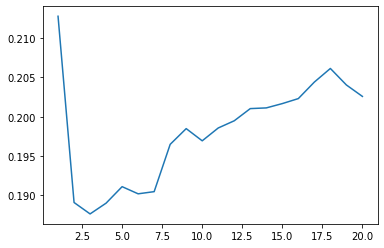

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(1,21), mean_val)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [32]:
mean_val_cos = np.empty(20)
for i in range(1,21):
    knn_cos = KNeighborsClassifier(n_neighbors=i, metric='cosine')
    mean_val_cos[i-1] = cross_val_score(knn_cos, X, target, cv=3).mean()

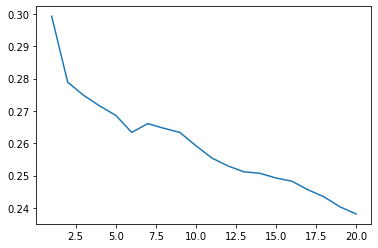

In [33]:
plt.plot(range(1,21), mean_val_cos)

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer 
X = TfidfTransformer().fit_transform(X)

In [35]:
mean_val_t = np.empty(20)
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    mean_val_t[i-1] = cross_val_score(knn, X, target, cv=3).mean()

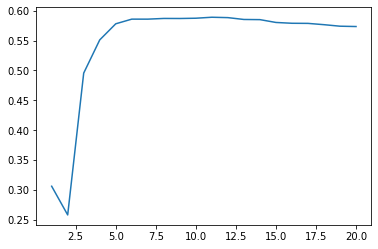

In [36]:
plt.plot(range(1,21), mean_val_t)

In [38]:
X = TfidfTransformer().fit_transform(X)
mean_val_cos_t = np.empty(20)
for i in range(1,21):
    knn_cos = KNeighborsClassifier(n_neighbors=i, metric='cosine')
    mean_val_cos_t[i-1] = cross_val_score(knn_cos, X, target, cv=3).mean()

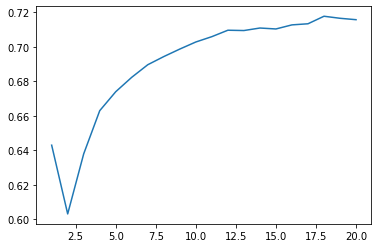

In [39]:
plt.plot(range(1,21), mean_val_cos_t)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [40]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
test_data = newsgroups['data']
test_target = newsgroups['target']

In [41]:
test_data_tok = list(list())
index = list()
for i in range(len(test_data)):
    s = test_data[i].lower()
    s = re.sub('[^a-z]+', ' ', s)
    s = s.split()
    if (len(s) != 0):
        test_data_tok.append(s)
    else:
        index.append(i)
        
test_target = np.delete(test_target, index)

In [42]:
X = []
for i in range(len(test_data_tok)):
    X.append(' '.join(test_data_tok[i]))
X = CountVectorizer().fit_transform(X)
X = TfidfTransformer().fit_transform(X)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [44]:
best_knn = KNeighborsClassifier(n_neighbors=10, metric='cosine').fit(X, test_target)
best_knn.score(X, test_target)

0.7302586560832078

Качество теста выше, чем в кросс-валидации. Возможно, на это повлияло изменение размера обучающей выборки 